<a href="https://colab.research.google.com/github/Hariomkumar42/AI-for-market-trend-analysis/blob/main/ai_for_market_trend_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

stock_symbol = 'RELIANCE.NS'
start_date = '2015-08-01'
end_date = '2025-08-01'

df = yf.download(stock_symbol, start=start_date, end=end_date)
df.dropna(inplace=True)
df.head()






/tmp/ipython-input-4215864994.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2015-08-03,218.082306,220.562370,217.418785,217.766868,9887787
2015-08-04,214.938766,218.778519,213.198378,218.289033,12006872
2015-08-05,214.884369,217.723394,214.090307,214.993140,14345010
2015-08-06,212.969925,215.808950,212.654487,215.591392,8708037
2015-08-07,214.144699,216.244048,212.578330,212.980800,8608888


In [ ]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
count,2468.000000,2468.000000,2468.000000,2468.000000,2.468000e+03
mean,800.969481,809.525976,793.002793,801.449150,1.818077e+07
std,422.365059,426.063081,418.865749,422.553572,1.358602e+07
min,180.468063,182.937214,177.955367,180.565955,0.000000e+00
25%,409.795151,413.808820,407.172981,410.676631,1.036577e+07
50%,871.982300,883.169876,863.822108,875.248654,1.431626e+07
75%,1170.813904,1182.272860,1161.307943,1170.579184,2.082881e+07
max,1595.484985,1603.358288,1580.137072,1599.022925,1.426834e+08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2468 entries, 2015-08-03 to 2025-07-31
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, RELIANCE.NS)   2468 non-null   float64
 1   (High, RELIANCE.NS)    2468 non-null   float64
 2   (Low, RELIANCE.NS)     2468 non-null   float64
 3   (Open, RELIANCE.NS)    2468 non-null   float64
 4   (Volume, RELIANCE.NS)  2468 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 115.7 KB


In [ ]:
df["Price Ticker"]=pd.to_datetime(df.index,format="%d-%b-%Y")
df.index=df['Price Ticker']

In [ ]:
df.rename(columns={"Price Ticker":"Date"},inplace=True)

In [ ]:
df.head()

Price,Close,High,Low,Open,Volume,Date
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,
Price Ticker,,,,,,
2015-08-03,218.082306,220.562370,217.418785,217.766868,9887787,2015-08-03
2015-08-04,214.938766,218.778519,213.198378,218.289033,12006872,2015-08-04
2015-08-05,214.884369,217.723394,214.090307,214.993140,14345010,2015-08-05
2015-08-06,212.969925,215.808950,212.654487,215.591392,8708037,2015-08-06
2015-08-07,214.144699,216.244048,212.578330,212.980800,8608888,2015-08-07


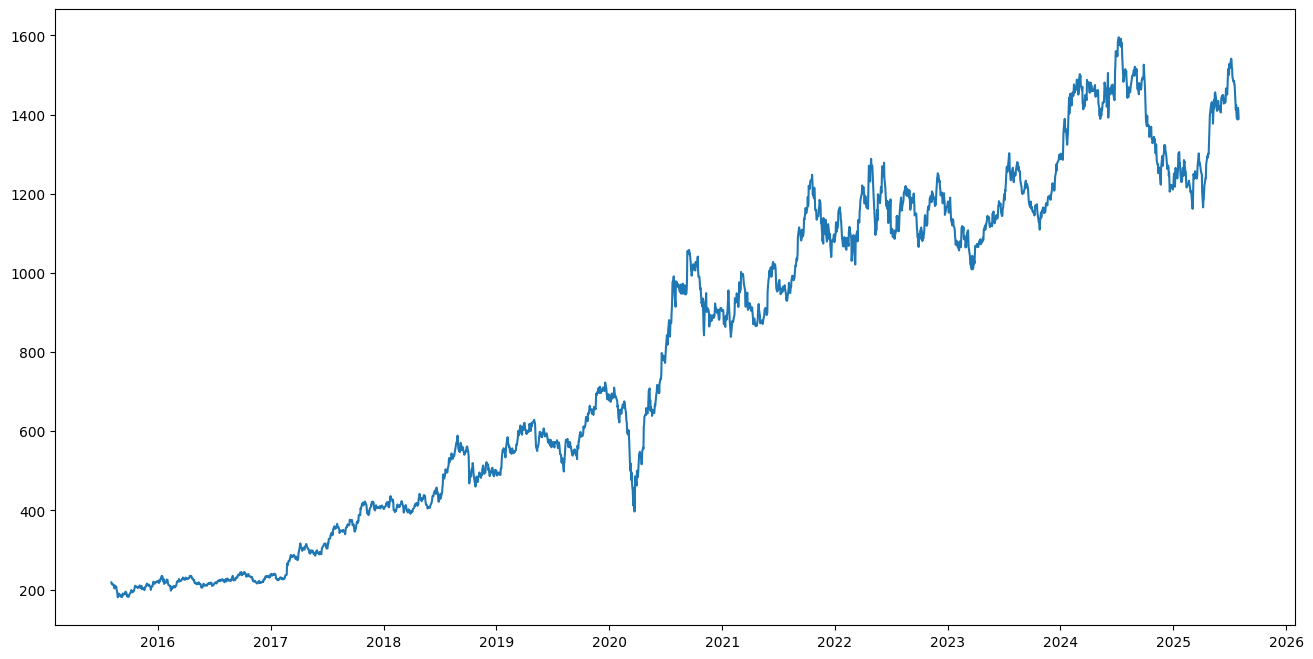

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [ ]:
data= df.sort_index(ascending=True,axis=0)
new_data=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

new_dataset=data[[('Close', 'RELIANCE.NS')]].reset_index()
new_dataset.columns = ['Date', 'Close'] # Rename the columns after resetting the index

In [ ]:
new_dataset.head()

,Date,Close
0,2015-08-03,218.082306
1,2015-08-04,214.938766
2,2015-08-05,214.884369
3,2015-08-06,212.969925
4,2015-08-07,214.144699


In [ ]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

In [ ]:
new_dataset.head()

,Close
Date,
2015-08-03,218.082306
2015-08-04,214.938766
2015-08-05,214.884369
2015-08-06,212.969925
2015-08-07,214.144699


In [ ]:
new_dataset.describe()

,Close
count,2468.000000
mean,800.969481
std,422.365059
min,180.468063
25%,409.795151
50%,871.982300
75%,1170.813904
max,1595.484985


In [ ]:
new_dataset.shape

(2468, 1)

In [ ]:
# split before scaling to prevent data leakage
train_data = new_dataset[:int(new_dataset.shape[0] * 0.8)]
valid_data = new_dataset[int(new_dataset.shape[0] * 0.8):]

In [ ]:
# scale only train data
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scalar.fit_transform(train_data)

x_train_data, y_train_data = [], []
for i in range(60, len(train_data)):
    x_train_data.append(scaled_train_data[i - 60:i, 0])
    y_train_data.append(scaled_train_data[i, 0])

x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data = np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1], 1))

In [ ]:

lstm_model = Sequential()
lstm_model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=150))
lstm_model.add(Dense(1))

inputs_data = new_dataset[len(new_dataset) - len(valid_data) - 60:].values
inputs_data = inputs_data.reshape(-1, 1)
inputs_data = scalar.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(x_train_data, y_train_data, epochs=5, batch_size=2, verbose=2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


957/957 - 73s - 76ms/step - loss: 0.0023
Epoch 2/5
957/957 - 67s - 70ms/step - loss: 6.7079e-04
Epoch 3/5
957/957 - 79s - 83ms/step - loss: 5.2088e-04
Epoch 4/5
957/957 - 84s - 88ms/step - loss: 6.0035e-04
Epoch 5/5
957/957 - 88s - 92ms/step - loss: 3.6066e-04


In [ ]:
X_test = []
for i in range(60, inputs_data.shape[0]):
    X_test.append(inputs_data[i - 60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scalar.inverse_transform(predicted_closing_price)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


In [ ]:
lstm_model.save("stock_model.h5")

/tmp/ipython-input-2195548844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = predicted_closing_price


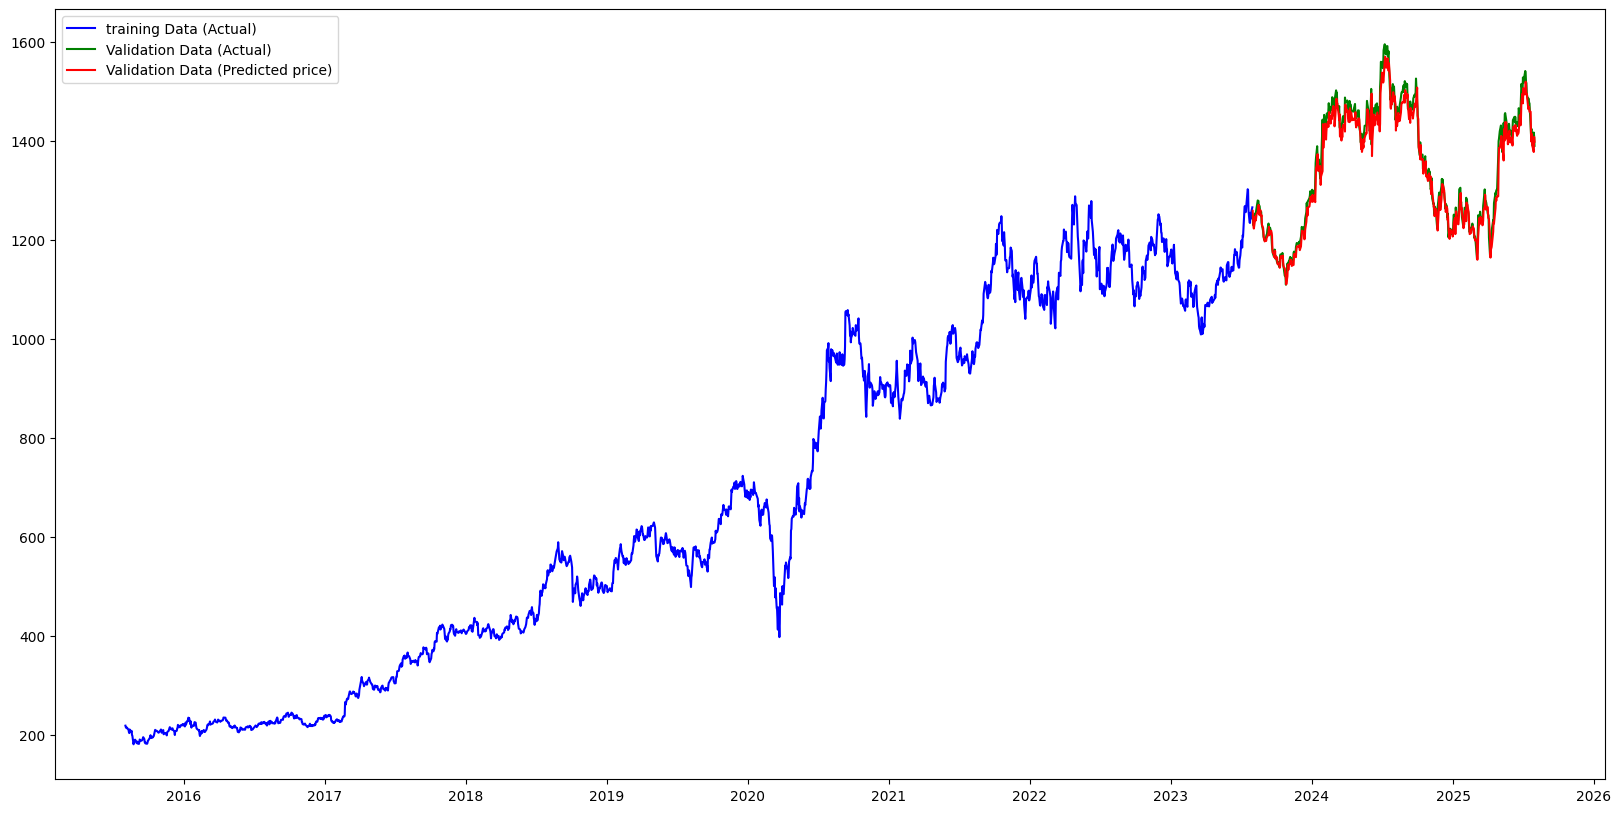

In [ ]:
train_data =  new_dataset[:int(new_dataset.shape[0] * 0.8)]
valid_data = new_dataset[int(new_dataset.shape[0] * 0.8):]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data["Close"],label="training Data (Actual)",color='blue')
plt.plot(valid_data["Close"],label="Validation Data (Actual)",color='green')
plt.plot(valid_data["Predictions"],label="Validation Data (Predicted price)",color='red')
plt.legend()
